In [169]:
#libraries
#----------------------------------------------------------------------------
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
#----------------------------------------------------------------------------

In [170]:
def compute_corr_from_yfinance(tickers, period='1mo', fallback=None):
    """
    Calcule dynamiquement une matrice de corrélation
    à partir des prix de clôture sur `period` des tickers donnés.

    - tickers : liste de tickers Yahoo Finance (ex: ['AAPL','SPY','MSFT']).
    - period  : fenêtre temporelle (ex: '1mo', '3mo').
    - fallback: matrice numpy (ou None). Si yfinance échoue, cette matrice est renvoyée.

    Si aucune donnée n'est récupérée et qu'aucun fallback n'est fourni, une RuntimeError est levée.
    """
    if isinstance(tickers, str):
        tickers = [tickers]

    # Désactive les configs d'impersonation qui posent problème dans certains environnements
    os.environ.pop('YF_IMPERSONATE', None)
    os.environ.pop('YF_SCRAPER_IMPERSONATE', None)
    try:
        yf.set_config(proxy=None)
    except Exception:
        pass

    try:
        data = yf.download(
            tickers=tickers,
            period=period,
            interval='1d',
            auto_adjust=True,
            progress=False,
        )
    except Exception as exc:
        if fallback is not None:
            print("Téléchargement yfinance échoué ({}), utilisation du fallback.".format(exc))
            return fallback
        raise

    if data.empty:
        if fallback is not None:
            print("Aucune donnée récupérée, utilisation du fallback.")
            return fallback
        raise RuntimeError("Aucune donnée de prix récupérée via yfinance pour les tickers fournis.")

    # Gestion du MultiIndex (colonnes) retourné par yfinance pour plusieurs tickers
    if isinstance(data.columns, pd.MultiIndex):
        if 'Adj Close' in data.columns.levels[0]:
            prices = data['Adj Close']
        else:
            prices = data['Close']
    else:
        # Cas d'un seul ticker
        if 'Adj Close' in data.columns:
            prices = data[['Adj Close']].copy()
        elif 'Close' in data.columns:
            prices = data[['Close']].copy()
        else:
            if fallback is not None:
                print("Colonnes de prix introuvables, utilisation du fallback.")
                return fallback
            raise RuntimeError("Colonnes de prix introuvables dans les données yfinance.")
        prices.columns = tickers

    # Rendements log quotidiens
    returns = np.log(prices / prices.shift(1)).dropna(how='any')
    if returns.empty:
        if fallback is not None:
            print("Pas assez de données de rendements, utilisation du fallback.")
            return fallback
        raise RuntimeError("Pas assez de données de rendements pour calculer la corrélation.")

    corr_mat = returns.corr().values
    return corr_mat



# Build and train a neural network model for pricing European Basket options under Black-Scholes assumptions.

In order to train a neural network we will need to generate data.

1.   Data Generation
2.   Building Model

**Methodology**

The first step is to create a set of combinations of model, option and market parameters (strike, maturities, volatility, riskfree rate, ...)

For the multi-asset case (basket option), the Scipy implementation of the numerically stable algorithm of Davies &
Higham is used to generate random correlation matrices of
underlyings.


In [171]:
#Global Variables :

# number of epochs to train the model on
EPOCHS = 50

BASE_PRICE   = 100
BASE_STRIKE  = 200

# Tickers sous-jacents (seront déduits du CSV de clôtures)
ASSETS = []

# Corrélation calculée plus bas à partir du CSV de clôtures.
# CORR_FALLBACK peut être utilisée si besoin.
CORR = None
CORR_FALLBACK = np.array([
    [1.0, 0.6, 0.4],
    [0.6, 1.0, 0.7],
    [0.4, 0.7, 1.0],
])


In [172]:
# Chargement du CSV de clôtures et calcul de la corrélation
closing_csv = 'data/closing_prices.csv'
closing_df = pd.read_csv(closing_csv)
# On suppose les colonnes : Date, et une colonne par ticker (ex: SPY, AAPL, MSFT)
price_cols = [c for c in closing_df.columns if c.lower() != 'date']
ASSETS = price_cols  # met à jour la liste des tickers
returns = np.log(closing_df[price_cols] / closing_df[price_cols].shift(1)).dropna(how='any')
CORR = returns.corr().values
CORR


array([[1.        , 0.23293856, 0.44203333],
       [0.23293856, 1.        , 0.66586223],
       [0.44203333, 0.66586223, 1.        ]])

In [173]:
class BasketOption:
  """
  Basket class
  """
  def __init__(self, weights, prices, volatility, corr, strike, maturity, rate):
    """
    args:
    - matuity : in years
    """
    self.weights = weights
    self.vol = volatility
    self.strike = strike
    self.mat = maturity
    self.rate = rate
    self.corr = corr
    self.prices = prices


  def get_mc(self, M=10000):
    
    '''
    reference : https://github.com/shrentseng/Numerical-methods-for-option-pricing/blob/main/Monte%20Carlo%20simulation%20option%20pricing.ipynb
    runs M paths of MC
    
    '''
    #B_Ts = np.random.normal(0, self.mat, M)
    B_Ts = stats.multivariate_normal(np.zeros(len(self.weights)), cov=self.corr).rvs(size=M)
    S_Ts = self.prices * np.exp((self.rate - 0.5 * self.vol ** 2) * self.mat + self.vol * B_Ts)
    if len(self.weights) > 1:
      payoffs = (np.sum(self.weights * S_Ts, axis=1) - self.strike).clip(0)
    else:    
      payoffs = np.maximum(S_Ts - self.strike, np.zeros(M)) 
    self.mc_price = np.mean(payoffs) 
    return np.exp(-1 * self.rate * self.mat) * self.mc_price


  def get_bs_price(self):
        d1 = 1 / (self.vol * (self.mat) ** 0.5) * (np.log(self.prices/self.strike)\
                                            + (self.rate + (0.5 * self.vol ** 2)) * self.mat)
        d2 = d1 - self.vol * self.mat ** 0.5
        self.bs_price = stats.norm.cdf(d1) * self.prices\
                        - stats.norm.cdf(d2) * self.strike * np.exp(-self.rate * self.mat)
        
        return self.bs_price

In [174]:
class DataGen:
  """
  Based on the class Basket option
  This class will simulate multiple baskets to train our model on
  """
  def __init__(self, n_assets, n_samples):
    """
    n_assets: number of assets contained in a portfolio ( basket )
    n_samples : number of baskets we are simulating
    """
    self.n_assets = n_assets
    self.n_samples = n_samples

    if (self.n_samples <= 0):
      raise ValueError("n_samples needs to be positive")

    if (self.n_assets <= 0):
      raise ValueError("n_assets needs to be positive")  


  def generate(self, corr=CORR, strike_price=BASE_STRIKE, base_price=BASE_PRICE, method='bs'):
    """
    - method : refers to the solver that will compute the labels
    it can be "bs" : for Black-Scholes or "mc" : Monte Carlo

    """

    mats = np.random.uniform(0.2, 1.1, size=self.n_samples)
    vols = np.random.uniform(0.01, 1, size=self.n_samples)
    rates = np.random.uniform(0.02, 0.1, size=self.n_samples)
    
    #add noise to strikes and prices
    strikes = np.random.randn(self.n_samples) + strike_price
    prices  = np.random.randn(self.n_samples) + base_price

    if self.n_assets > 1:
      weights = np.random.rand(self.n_samples * self.n_assets).reshape((self.n_samples, self.n_assets))
      weights /= np.sum(weights, axis=1)[:, np.newaxis]
    else:
      weights = np.ones((self.n_samples, self.n_assets))

    labels = []
    for i in range(self.n_samples):
      basket = BasketOption(weights[i], prices[i],
                                  vols[i], corr, strikes[i], 
                                  mats[i], rates[i])
      if method == "bs":
        labels.append(basket.get_bs_price())
      else: 
        labels.append(basket.get_mc())

    print(len(labels))
    self.data = pd.DataFrame({
                         'S/K' : prices / strikes,
                         'Maturity': mats,
                         'Volatility': vols,
                         'Rate': rates,
                         'Labels': labels,
                         'Prices': prices,
                         'Strikes': strikes})
    
    for i in range(self.n_assets):
      self.data['Weight_{}'.format(i)] = weights[:,i]

    #save the dataframe to csv format
    return self.data

Our Goal is to Build and train a neural network model for pricing European Basket options under Black-Scholes assumptions. So our ground truth will be generated using  Black-Scholes function.

In [175]:
def simulate(n_assets=3, n_samples=10000, method="bs"):
  """
  Generates data based on the Datagen class
  args:
  - n_assets : number of assets contained in a Basket
  - n_samples : number of training examples
  - method : method used to compute the price it can be "mc" or "bs"
  """ 
  simulator = DataGen(3, n_samples=n_samples)
  simulated_prices = simulator.generate(method=method)
  return simulated_prices

In [176]:
%time 

data = simulate()
data

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.01 μs
10000


,S/K,Maturity,Volatility,Rate,Labels,Prices,Strikes,Weight_0,Weight_1,Weight_2
0,0.496584,0.953271,0.553925,0.099314,4.693177e+00,99.440009,200.248200,0.808438,0.076944,0.114618
1,0.499481,1.021528,0.057028,0.027160,2.179130e-31,99.438588,199.083873,0.285222,0.128159,0.586619
2,0.500646,0.807417,0.292906,0.095944,1.171434e-01,99.618442,198.979639,0.621107,0.102991,0.275902
3,0.501916,0.291253,0.177225,0.099832,4.727004e-12,100.343118,199.920097,0.287352,0.363234,0.349414
4,0.499100,0.678701,0.180285,0.072486,2.968651e-05,100.296592,200.955061,0.427508,0.414624,0.157868
...,...,...,...,...,...,...,...,...,...,...
9995,0.484484,0.405143,0.345009,0.045690,5.264533e-03,96.867048,199.938441,0.480776,0.272598,0.246626
9996,0.501518,1.044479,0.790225,0.048675,1.293899e+01,100.055503,199.505263,0.200159,0.592571,0.207270
9997,0.505944,0.621101,0.053109,0.066609,1.700820e-53,101.860383,201.327193,0.502054,0.473394,0.024552
9998,0.511839,0.231553,0.592777,0.076203,1.516075e-01,101.438643,198.184666,0.217140,0.332359,0.450501


# Choosing Model Features 

Based on this paper : https://canopee-group.com/wp-content/uploads/2020/12/Machine-Learning-methods-Coperneec.pdf

The important features to consider for the model construction while dealing with European basket call (BS) 
are :

- Maturity 
- Risk
- the ratio S/k (Moneyness) 
- Volatility

**Methodology**

Before building the model we will be splitting our data then :          
- Save train and test into csv formats
- keep only the selected features

**Model Description:**

The model is build using the functional API of keras .
It is composed of Dense layers, BatchNormalization layer and Dropout layer to prevent overfitting .
The last layer is a Dense layer with 1 neuron as we are dealing with a regression problem and an activation function : relu because the Price option needs to be at least 0.

In [177]:
def split_data(data, split_ratio=0.7):
  """
  splits the data into train and test
  
  args:
  data : pd.Dataframe : represents simulated data
  split_ratio: the factor to spli data into train and test

  returns:
  x_train, y_train, x_test, y_test
  """
  train = data.iloc[:int(split_ratio * len(data)), :]
  test  = data.iloc[int(split_ratio * len(data)):, :]
  train.to_csv("train.csv", index=False)
  test.to_csv("test.csv", index=False)
  x_train, y_train = train.iloc[:, 0:4], train.iloc[:, 4]
  x_test, y_test = test.iloc[:, 0:4], test.iloc[:, 4]
  return x_train, y_train, x_test, y_test
  
x_train, y_train, x_test, y_test = split_data(data, split_ratio=0.7)

def build_model(epochs=EPOCHS):
  #build model using functional method
  input = Input(shape=(x_train.shape[1],))
  x = Dense(32, activation='relu')(input)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu')(x)
  x = BatchNormalization()(x)
  output = Dense(1, activation='relu')(x)

  model = Model(inputs= input, outputs=output)
  return model

In [178]:
model = build_model()
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=["mean_squared_error"])

history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test))


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.1628 - mean_squared_error: 8.1628 - val_loss: 20.2884 - val_mean_squared_error: 20.2884
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1944 - mean_squared_error: 2.1944 - val_loss: 10.2915 - val_mean_squared_error: 10.2915
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6091 - mean_squared_error: 1.6091 - val_loss: 4.6855 - val_mean_squared_error: 4.6855
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3202 - mean_squared_error: 1.3202 - val_loss: 3.1520 - val_mean_squared_error: 3.1520
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1499 - mean_squared_error: 1.1499 - val_loss: 2.4071 - val_mean_squared_error: 2.4071
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0766 - mean_squared_error: 1.0766 - val_loss: 0.9010 - val_mean_squared_error: 0.9010
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9525 - mean_squared_error: 0.9525 - val_loss: 

Compute Model Predictions on test data

In [179]:
start = time.time()
predictions = model.predict(x_test)
end = time.time()
print(f"Runtime of the model on test set is {end - start}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Runtime of the model on test set is 0.4355754852294922


In [180]:
def price_basket_nn(model, S=None, K=None, S_over_K=None, maturity=1.0, volatility=0.2, rate=0.01):
    """
    Pricing helper basé sur le réseau de neurones entraîné.

    On peut fournir directement S/K via `S_over_K`, ou bien S et K.
    Les autres paramètres sont la maturité (en années), la volatilité et le taux sans risque.
    """
    if S_over_K is None:
        if S is None or K is None:
            raise ValueError("Fournir soit S_over_K, soit (S et K).")
        S_over_K = S / K
    x = np.array([[float(S_over_K), float(maturity), float(volatility), float(rate)]], dtype=float)
    price = float(model.predict(x, verbose=0)[0, 0])
    return price

# Exemple d'appel :
# price_basket_nn(model, S=100, K=200, maturity=0.5, volatility=0.3, rate=0.02)


# Optional : Model Performance plotting

In [181]:
def plot_performance(history):
  plt.plot(history.history['mean_squared_error'])
  plt.plot(history.history['val_mean_squared_error'])
  plt.ylabel('MAE')
  plt.xlabel("epoch")
  plt.legend(['train', 'test'])
  plt.show();

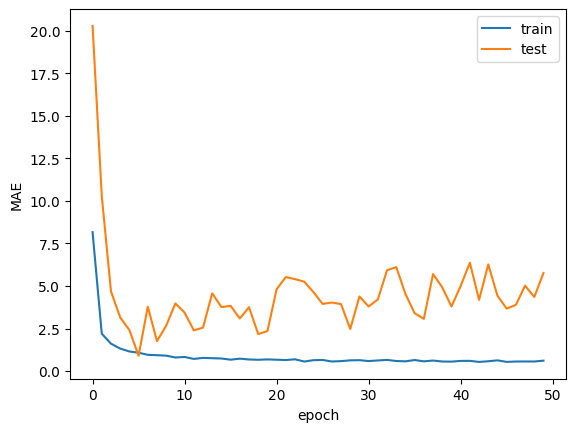

In [182]:
plot_performance(history);

In [183]:
print("maximum train option price :" , y_train.max())
print("mean train option price : " , np.mean(y_train))

maximum train option price : 21.968158577374762
mean train option price :  3.3065349552978276


We notice that compared to the values of the dataset the MEA for the training data is pretty low for this simple regression model .

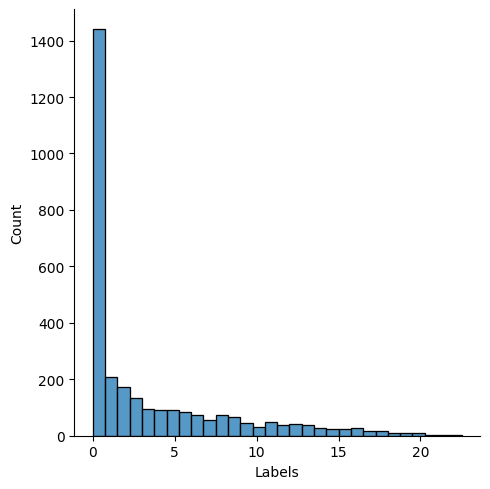

In [184]:
#Plot test labels distribution
sns.displot(y_test)

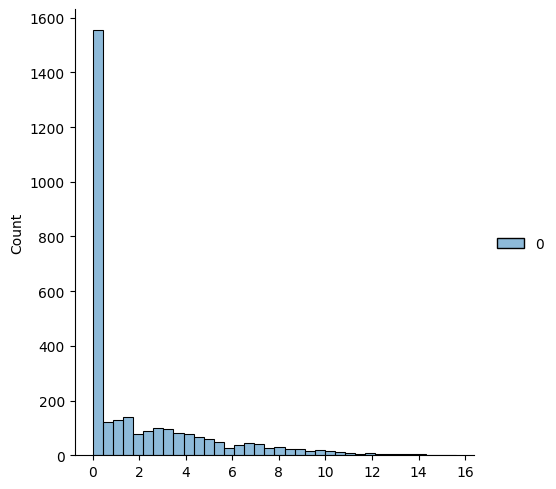

In [185]:
#Plot prediction distribution
sns.displot(predictions)

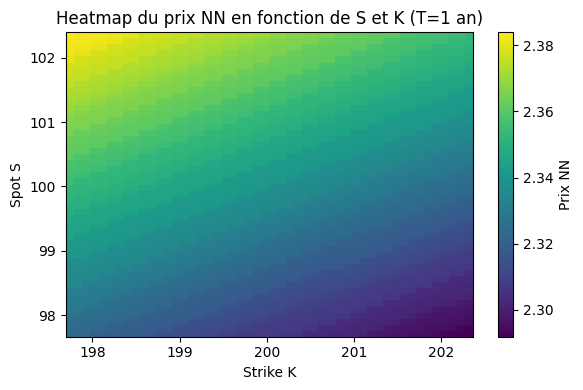

In [186]:
# Heatmap du prix NN en fonction de S (spot) et K (strike) pour T = 1 an

# Plage de S et K basée sur les quantiles des données
S_min, S_max = data['Prices'].quantile([0.01, 0.99])
K_min, K_max = data['Strikes'].quantile([0.01, 0.99])
n_S = 50
n_K = 50
S_vals = np.linspace(S_min, S_max, n_S)
K_vals = np.linspace(K_min, K_max, n_K)

# Grille (S, K) : S en axe vertical, K en axe horizontal
K_grid, S_grid = np.meshgrid(K_vals, S_vals)
S_over_K_grid = S_grid / K_grid

T_fixed = 1.0  # 1 an
sigma_ref = float(data['Volatility'].median())
rate_ref = float(data['Rate'].median())

X_SK = np.stack([
    S_over_K_grid.ravel(),
    np.full(S_over_K_grid.size, T_fixed),
    np.full(S_over_K_grid.size, sigma_ref),
    np.full(S_over_K_grid.size, rate_ref),
], axis=1)

prices_SK = model.predict(X_SK, verbose=0).reshape(n_S, n_K)

plt.figure(figsize=(6, 4))
im2 = plt.imshow(
    prices_SK,
    origin='lower',
    extent=[K_vals.min(), K_vals.max(), S_vals.min(), S_vals.max()],
    aspect='auto',
    cmap='viridis',
)
plt.xlabel('Strike K')
plt.ylabel('Spot S')
plt.title('Heatmap du prix NN en fonction de S et K (T=1 an)')
plt.colorbar(im2, label='Prix NN')
plt.tight_layout()
plt.show()


# Compare prices to a traditional numerical solver such as Monte-Carlo, Finite Difference or any other methodology you may deem applicable.

In this part we will be using Monte Carlo for computing Basket option price.
we will be working on testing set . So we will load the test set that we saved earlier.

**Methodology:**

For making using of the MC simulations I used a function defined in this notebook  that uses MC for a call option : https://github.com/shrentseng/Numerical-methods-for-option-pricing/blob/main/Monte%20Carlo%20simulation%20option%20pricing.ipynb 
But as I am dealing with a Basket so when computing the payoff I need to pay attention to the weights.

In [187]:
import os
if os.path.exists("test.csv"):
  print("Downloading test csv file .......") 
  test = pd.read_csv("test.csv")

In [188]:
test.head()

,S/K,Maturity,Volatility,Rate,Labels,Prices,Strikes,Weight_0,Weight_1,Weight_2
0,0.495490,0.559856,0.557194,0.062203,1.316739,99.086662,199.977088,0.164253,0.336485,0.499262
1,0.502309,0.414144,0.947808,0.073823,5.904024,100.334010,199.745484,0.266381,0.384060,0.349559
2,0.497526,0.826767,0.230786,0.051648,0.007096,99.689524,200.370426,0.456228,0.147795,0.395977
3,0.497807,0.902847,0.448614,0.073692,1.759553,99.866530,200.613113,0.317691,0.451497,0.230812
4,0.491395,0.409256,0.414130,0.069966,0.058315,99.109197,201.689470,0.242305,0.350072,0.407623


In [189]:
#Define a Monte carlo MC price empty list 
%time 
start = time.time()
mc_prices = []
for i in range(test.shape[0]):
    basket = BasketOption(
        test.iloc[i,7:].to_numpy(),
        test.iloc[i].Prices,
        test.iloc[i].Volatility,
        CORR,
        test.iloc[i].Strikes,
        test.iloc[i].Maturity,
        test.iloc[i].Rate
    )
    mc_prices.append(basket.get_mc())
end = time.time()
print(f"Runtime of MC is : .... {end - start}")    

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.01 μs
Runtime of MC is : .... 2.7816519737243652


# Compare to the case of 1 asset

In the case of 1 asset the correlation matrix takes one value :

So we will have same work as before with :

- corr = np.array([[1,]]) 
- n_assets = 1


In [190]:
len(test)

3000

Summary :

The Main Goal of the client is explore novel methodologies for accelerating the pricing of exotic derivatives. The Client cares a lot about the time that an algorithm consumes to compute Option Price 

From  our experiment : with 10 000 data points and with 3000 data points on the test set the Neural network model needs  0.12 seconds to run and the MC algorithm needs 9.85 seconds to run.



0.027257271111011505

# IV Surface helpers (importés depuis iv_surface.ipynb)

Ces fonctions permettent de charger un CSV Basket (colonnes `Strikes`, `Maturity`, `Volatility`)
et d'afficher une surface de volatilité implicite (3D + heatmap).


In [192]:
from pathlib import Path

def build_grid(
    df: pd.DataFrame,
    S0: float,
    n_K: int = 200,
    n_T: int = 200,
    K_min: float | None = None,
    K_max: float | None = None,
    T_min: float | None = None,
    T_max: float | None = None,
    K_span: float | None = None,
    margin_frac: float = 0.02,
):
    """Construit une grille régulière (K, T) et moyenne les IV dans chaque cellule.

    - Si `K_min/K_max` ne sont pas fournis, on les déduit des données avec une marge.
    - Sinon, on peut forcer une fenêtre via `K_span` autour de `S0`.
    - Les bornes en maturité sont par défaut celles du dataset.
    """

    if K_min is None or K_max is None:
        if K_span is not None:
            K_min = S0 - K_span
            K_max = S0 + K_span
        else:
            data_K_min = float(df["K"].min())
            data_K_max = float(df["K"].max())
            delta_K = data_K_max - data_K_min
            pad = delta_K * margin_frac
            K_min = data_K_min - pad
            K_max = data_K_max + pad

    if T_min is None:
        T_min = float(df["T"].min())
    if T_max is None:
        T_max = float(df["T"].max())

    if K_min >= K_max:
        raise ValueError("K_min doit être inférieur à K_max.")
    if T_min >= T_max:
        raise ValueError("T_min doit être inférieur à T_max.")

    K_vals = np.linspace(K_min, K_max, n_K)
    T_vals = np.linspace(T_min, T_max, n_T)

    df = df[(df["K"] >= K_min) & (df["K"] <= K_max)].copy()
    df = df[(df["T"] >= T_min) & (df["T"] <= T_max)]

    if df.empty:
        raise ValueError("Aucun point n'appartient au domaine défini par la grille.")

    df["K_idx"] = np.searchsorted(K_vals, df["K"], side="left").clip(0, n_K - 1)
    df["T_idx"] = np.searchsorted(T_vals, df["T"], side="left").clip(0, n_T - 1)

    grouped = df.groupby(["T_idx", "K_idx"])["iv"].mean().reset_index()

    iv_grid = np.full((n_T, n_K), np.nan, dtype=float)
    for _, row in grouped.iterrows():
        iv_grid[int(row["T_idx"]), int(row["K_idx"])] = row["iv"]

    K_grid, T_grid = np.meshgrid(K_vals, T_vals)
    return K_grid, T_grid, iv_grid

def plot_surface(K_grid, T_grid, iv_grid, title_suffix=""):
    """Affiche surface 3D + heatmap 2D de la volatilité implicite."""
    fig = plt.figure(figsize=(12, 5))

    ax3d = fig.add_subplot(1, 2, 1, projection="3d")
    iv_flat = iv_grid[~np.isnan(iv_grid)]
    if iv_flat.size == 0:
        raise ValueError("La grille IV est entièrement vide.")
    iv_mean = iv_flat.mean()
    iv_fill = np.where(np.isnan(iv_grid), iv_mean, iv_grid)

    surf = ax3d.plot_surface(
        K_grid,
        T_grid,
        iv_fill,
        rstride=1,
        cstride=1,
        linewidth=0.2,
        antialiased=True,
        cmap="viridis",
    )
    ax3d.set_xlabel("Strike K")
    ax3d.set_ylabel("Maturité T (années)")
    ax3d.set_zlabel("Implied vol")
    ax3d.set_title(f"Surface IV 3D{title_suffix}")
    fig.colorbar(surf, ax=ax3d, shrink=0.6, aspect=10, label="iv")

    ax2d = fig.add_subplot(1, 2, 2)
    im = ax2d.imshow(
        iv_fill,
        extent=[K_grid.min(), K_grid.max(), T_grid.min(), T_grid.max()],
        origin="lower",
        aspect="auto",
        cmap="viridis",
    )
    ax2d.set_xlabel("Strike K")
    ax2d.set_ylabel("Maturité T (années)")
    ax2d.set_title(f"Heatmap IV{title_suffix}")
    fig.colorbar(im, ax=ax2d, label="iv")

    plt.tight_layout()
    plt.show()

def load_iv_dataframe(csv_path: Path):
    """Charge un CSV Basket/data et renvoie (df_iv, S0_estime).
    Attend les colonnes 'Strikes', 'Maturity', 'Volatility'.
    """
    df = pd.read_csv(csv_path)
    required_cols = {"Strikes", "Maturity", "Volatility"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Colonnes manquantes: {required_cols - set(df.columns)}")

    df_iv = pd.DataFrame({
        "K": df["Strikes"],
        "T": df["Maturity"],
        "iv": df["Volatility"],
    })

    if "Prices" in df.columns:
        S0 = float(df["Prices"].mean())
    elif "S/K" in df.columns and "Strikes" in df.columns:
        S0 = float((df["S/K"] * df["Strikes"]).mean())
    else:
        S0 = float(df["Strikes"].mean())

    return df_iv, S0


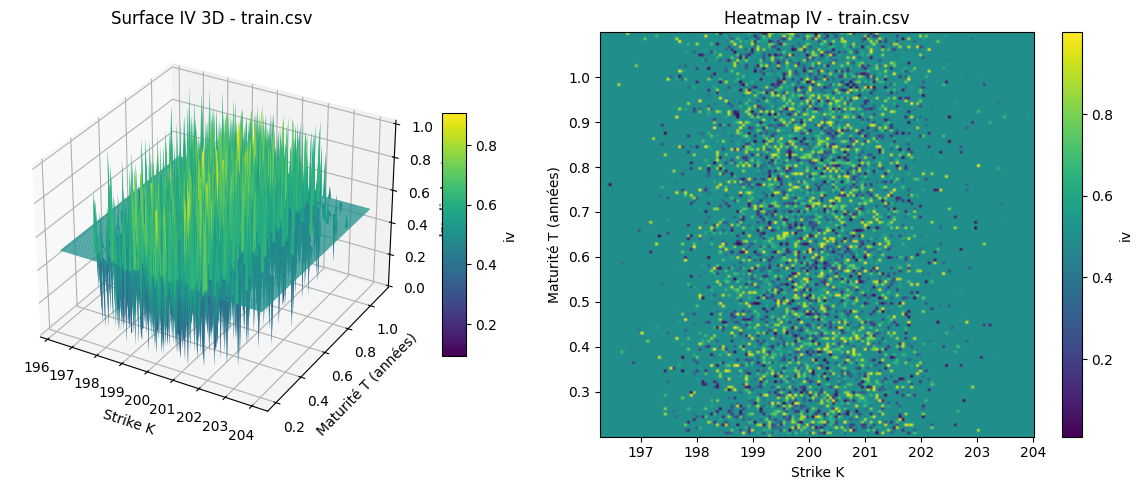

In [194]:
# Exemple d'utilisation avec un CSV (train.csv de simulation)
csv_iv = Path('train.csv')
if csv_iv.exists():
    iv_df, S0_est = load_iv_dataframe(csv_iv)
    K_grid, T_grid, iv_grid = build_grid(iv_df, S0=S0_est, n_K=150, n_T=150)
    plot_surface(K_grid, T_grid, iv_grid, title_suffix=' - train.csv')
else:
    print(f'Fichier introuvable: {csv_iv}')
